In [1]:
#!/usr/bin/env python

#comment out if not using jupyter
%matplotlib inline 

#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import odeint
from scipy.optimize import curve_fit

#from scipy.stats import pearsonr,spearmanr
#from scipy.interpolate import interp1d


In [30]:
## functions to do the whole fitting process ##

#use nested functions to pass in initial viral load 
#becaues this determines other initial conditions
def make_solver(V0,flg):

    #fixed parameters for fitting
    aS  = 70;    #constant growth rate of susceptibles [cells/uL/day]
    Bt0 = 1e-4   #infection rate of T-cells [uL/cells-day]/[uL]
    dI  = 0.8    #active death rate [1/day]
    p   = 5e4    # burst rate of virus from cells [virions/cell]
    g   = 23     #virus clearance rate [1/day]
    lam = 1e-4   #latency probability []
    thL = 5.2e-4 #latent clearance rate [1/day]
    aE  = 1e-4;  #initial E cell concentration [cells/uL]*[uL]

    if flg=='params':
        return aS,Bt0,dI,p,g,lam,thL,aE
    
    #complete HIV primary infection model for fitting
    def full_model(X,t,aS,dS,Bt0,tau,lam,dI,thL,k,aE,dE,E50,w,p,g):
        dY = np.zeros(7);
        S=X[0]; AU=X[1]; AP=X[2]; LU=X[3]; LP=X[4]; E=X[5]; V=X[6];    
        dY[0] = aS - dS*S - Bt0*S*V                         #susceptible cells
        dY[1] = (1-tau)*(1-lam)*Bt0*S*V - dI*AU - k*E*AU    #active unproductively infected
        dY[2] = tau*(1-lam)*Bt0*S*V - dI*AP - k*E*AP        #active productively infected
        dY[3] = (1-tau)*lam*Bt0*S*V - thL*LU                #latent unproductively infected
        dY[4] = tau*lam*Bt0*S*V - thL*LP                    #latent productively infected
        dY[5] = aE + w*E*(AP+AU)/(E+E50) - dE*E;            #adaptive immune system
        dY[6] = p*AP - g*V - Bt0*S*V                        #virus
        return dY
    
    #the model that has the right number of estimated params and will be fit
    def solve_model(tt,dS,tau,k,dE,E50,w):  
        #set up initial conditions
        S0=aS/dS; E0=aE/dE #compute equilibria for these    
        I0=g/p*V0 #quasistatic approximation for VL and infected cells
        #calculate the rest of initial conditions from more quasistatic approx
        X0=np.array([S0,
                     I0*(1-tau)*(1-lam), #unproductive active
                     I0*tau*(1-lam),     #productive active
                     I0*(1-tau)*lam,     #unproductive latent
                     I0*tau*lam,         #productive latent
                     E0,
                     V0])

        #solve model using initialize for initial conditions
        sol=odeint(full_model, X0, tt, (aS,dS,Bt0,tau,lam,dI,thL,k,aE,dE,E50,w,p,g), mxstep=10000) 
        VL=np.log10(sol[:,6]*1e3) #viral load as usual units copies/mL
        
        if flg=='fit':
            return VL
        if flg=='sim':
            return sol
        else:
            print('specify your model to be fit or simulated')
        
    return solve_model

#function to make arrays for boundaries during fitting process
def make_bounds(guess,fac):
    bounds=tuple([tuple(np.array(guess)/fac),tuple(np.array(guess)*fac)])
    return bounds

In [3]:
#import files, separated by region currently
thai=pd.read_csv('data/robb-scrape/wpd_thai.csv')
africa=pd.read_csv('data/robb-scrape/wpd_africa.csv')

N_thai=int(len(thai.columns)/2)
N_africa=int(len(africa.columns)/2)
N=N_thai+N_africa

df=pd.DataFrame(columns=['days','VL','ppt'])

#loop through each and make a big organized dataframe
goodN=0 #the number of individuals that have good data to fit
for i in range(N_thai):
    x=np.array(pd.to_numeric(thai.iloc[1:,2*i]))
    y=np.array(pd.to_numeric(thai.iloc[1:,2*i+1]))
    indz=np.argsort(x) #make sure time is in order
    dat=np.array([x[indz],y[indz],np.ones([len(indz)])*goodN])
    df2=pd.DataFrame(dat.T,columns=['days','VL','ppt']).dropna()
    #throw some data sets out that won't work for fitting
    if max(df2['days']/7)<4 or len(df2['days'])<5:
        print(i,'badset')
    else:
        df=df.append(df2,ignore_index=True)
        goodN+=1
for i in range(N_africa):
    x=np.array(pd.to_numeric(africa.iloc[1:,2*i]))
    y=np.array(pd.to_numeric(africa.iloc[1:,2*i+1]))
    indz=np.argsort(x) #make sure time is in order
    dat=np.array([x[indz],y[indz],np.ones([len(indz)])*goodN])
    df2=pd.DataFrame(dat.T,columns=['days','VL','ppt']).dropna()
    #throw some data sets out that won't work for fitting
    if max(df2['days']/7)<4 or len(df2['days'])<5:
        print(i,'badset')
    else:
        df=df.append(df2,ignore_index=True)
        goodN+=1


6 badset
24 badset
28 badset


In [4]:
#list of initial guesses of parameters to fit
dS  = 0.2;   #susceptible death rate [1/day] 
tau = 0.05   #productive infection probability []
k   = 0.3;   #immune cell killing rate [uL/cell-day]/[uL]
w   = 1.6;   #immune cell multiplier [1/day]
dE  = 0.002; #immune death rate [1/day]
E50 = 250;   #50 pct max E cell concentration [cells/uL]*[uL]

guessed_params=dS,tau,k,dE,E50,w


In [10]:
#loop through all good individual data sets and fit 
estimated_params=[]
for ppt in range(goodN):
    
    fitdat=df[df['ppt']==ppt] #loop through each individual    

    V0=fitdat['VL'].iloc[0] #assume starts at V_data from the actual data, not fitting initial time of infection
    
    #model fit
    po,pc=curve_fit(make_solver(V0,'fit'), 
                    fitdat['days'], fitdat['VL'], 
                    p0=guessed_params, 
                    bounds=make_bounds(guessed_params,10),
                    sigma=0.1*np.ones(len(fitdat['VL'])),absolute_sigma=False,
                    max_nfev=1e3, verbose=1, xtol=1e-15, ftol=1e-15, gtol=1e-15)

    estimated_params.append(list(po))


`xtol` termination condition is satisfied.
Function evaluations 35, initial cost 4.7229e+02, final cost 2.0082e+02, first-order optimality 9.97e+01.


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in log10


`xtol` termination condition is satisfied.
Function evaluations 40, initial cost 2.8969e+03, final cost 4.4634e+02, first-order optimality 2.00e+03.
`xtol` termination condition is satisfied.
Function evaluations 75, initial cost 1.7281e+03, final cost 2.3316e+02, first-order optimality 4.36e+01.
`xtol` termination condition is satisfied.
Function evaluations 32, initial cost 1.1874e+03, final cost 1.2877e+02, first-order optimality 1.79e+02.
`xtol` termination condition is satisfied.
Function evaluations 29, initial cost 6.0751e+02, final cost 7.9926e+01, first-order optimality 1.38e+02.
`xtol` termination condition is satisfied.
Function evaluations 37, initial cost 3.8957e+02, final cost 1.0937e+02, first-order optimality 2.97e+02.
`xtol` termination condition is satisfied.
Function evaluations 33, initial cost 8.7434e+02, final cost 1.0604e+02, first-order optimality 2.73e+01.
`xtol` termination condition is satisfied.
Function evaluations 30, initial cost 3.0122e+02, final cost 4.

In [70]:
len(estimated_params)

48

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


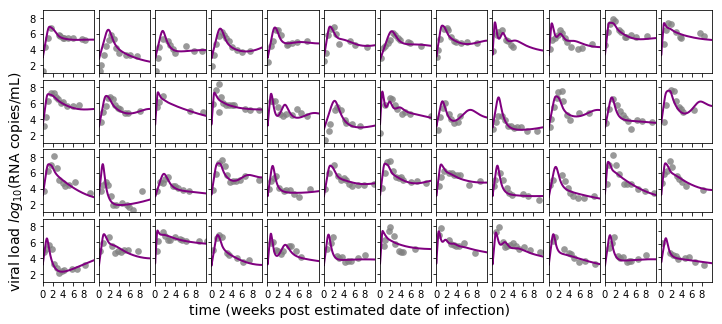

In [49]:
#plot model fitting results
nx=12; ny=4;
fig,axarr=plt.subplots(ny,nx,sharey=True,sharex=True,
                       figsize=(12,5),
                       gridspec_kw={'wspace':0.1,'hspace':0.1})

t_sim=np.linspace(0,7*10,1e3);

#loop through good data sets
for i in range(len(estimated_params)):    

    dS,tau,k,dE,E50,w=estimated_params[i]

    V_sim=make_solver(V0,'fit')(t_sim,dS,tau,k,dE,E50,w)

    fitdat=df[df['ppt']==i] #loop through each individual    

    axarr[int(i/nx)][i%nx].scatter(fitdat['days']/7,fitdat['VL'],c='gray',marker='o',lw=0,s=45,alpha=0.8)
    axarr[int(i/nx)][i%nx].plot(t_sim/7,V_sim,lw=2,color='purple')

plt.xlim([0,10])
plt.xticks(range(0,10,2))
plt.ylim([1,9])
plt.yticks(range(0,11,2))
axarr[2][0].set_ylabel('viral load $log_{10}$(RNA copies/mL)',fontsize=14)
axarr[3][5].set_xlabel('time (weeks post estimated date of infection)',fontsize=14)
#plt.tight_layout()
plt.savefig('figures/myrobb_fits.pdf',dpi=600)


medians for below
0.2529325219455597
0.04955197518646103
0.3352567373886677
0.002137462709757337
223.37812815120344
2.158321821244896


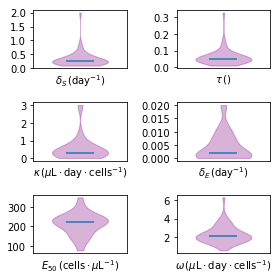

In [27]:
#make violin plots of all parameters
ep=np.array(estimated_params)

pnamez=[r'$\delta_S \, (\mathrm{day}^{-1})$',
        r'$\tau \, ()$',
        r'$\kappa \, (\mu\mathrm{L}\cdot \mathrm{day}\cdot \mathrm{cells}^{-1})$',
        r'$\delta_E \, (\mathrm{day}^{-1})$',
        r'$E_{50} \, (\mathrm{cells}\cdot\mu\mathrm{L}^{-1})$',
        r'$\omega \, (\mu\mathrm{L}\cdot \mathrm{day}\cdot \mathrm{cells}^{-1})$']
    
plt.figure(figsize=(4,4))
thaipm=[]
africapm=[]
print('medians for below')
#ylimz=[[1e-2,10],[1e-2,1],[1e-2,10],[1e-4,0.1],[50,1e3],[1,10]]
ylimz=[[0,2],[0,0.4],[0,10],[0,0.02],[0,300],[0,10]]
for i in range(len(estimated_params[0])):
    plt.subplot(321+i)

    #plt.scatter(np.random.normal(1,0.05,[len(po_arr[i,:])]),po_arr[i,:],alpha=0.2,s=10,color='gray')
    #plt.boxplot(po_arr[i,:],widths=0.5)
    vp=plt.violinplot(ep[:,i],widths=0.6,showextrema=False,showmedians=True)
    print(np.median(ep[:,i]))
    for pc in vp['bodies']:
        pc.set_facecolor('purple')
        pc.set_edgecolor('purple')

    #plt.yscale('log')
    plt.xlim([0.5,1.5])
    plt.locator_params(nbins=5)

    #plt.ylim(ylimz[i])
    plt.xlabel(pnamez[i])
    #plt.legend([pz[i]],loc=2)
    plt.xticks([])
    #plt.xticks([1],[pz[i]])
plt.tight_layout()
plt.savefig('figures/myrobb_paramfitsVIOL.pdf',dpi=600)


In [31]:
#check all the reproductive numbers and store all the variable parameters
R0=[]; pls=[]

aS,Bt0,dI,p,g,lam,thL,aE=make_solver(0,'params')

for i in range(len(estimated_params)):
    dS,tau,k,dE,E50,w=estimated_params[i]        
    R0.append(aS*Bt0*tau*(1-lam)*p/g/dS/dI-k*aE/dE); # basic reproductive number after first positive
    pls.append([R0[i],dS,tau,k,dE,E50,w])
    
pd.DataFrame.to_csv(pd.DataFrame(
                    np.array(pls)),#columns=['R0','dS','tau','k','dE','E50','w']),
                    'data/viral_dynamics.csv')



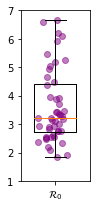

In [35]:
plt.figure(figsize=(1.5,3))
plt.scatter(np.random.normal(1,0.2,len(R0)),R0,color='purple',alpha=0.5)
plt.boxplot(R0,widths=1.2)

plt.xlim([0,2])
plt.xticks([1],[r'$\mathcal{R}_0$'])
plt.ylim([1,7])
#plt.yticks(range(0,11,2))
plt.tight_layout()
plt.savefig('figures/myrobb_R0s.pdf',dpi=600)


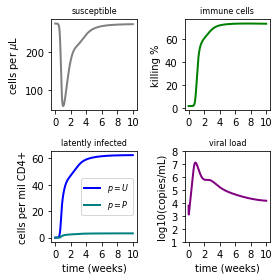

In [56]:
#simulate host-cell states

#dS,tau,k,dE,E50,w=estimated_params[2]
dS,tau,k,dE,E50,w=np.median(estimated_params,0)

sol=make_solver(V0,'sim')(t_sim,dS,tau,k,dE,E50,w)

t=t_sim/7

plt.figure(figsize=(4,4))

plt.subplot(221)
plt.plot(t,sol[:,0],'gray',lw=2)
plt.ylabel('cells per $\mu$L')
plt.title('susceptible',fontsize=8)

'''
plt.subplot(152)
plt.plot(t,sol[:,1],'red',lw=2)
plt.plot(t,sol[:,2],'orange',lw=2)
plt.ylabel('cells per $\mu$L')
plt.legend(['$U$','$P$'],fontsize=8)
plt.title('actively infected',fontsize=8)
'''

plt.subplot(222)
#plt.plot(t,sol[:,5],'green',lw=2) #immune cells
plt.plot(t,sol[:,5]*k/(dI+sol[:,5]*k)*100,'green',lw=2) #fraction from immunity (It cancels out)
#plt.ylabel('cells per $\mu$L')
plt.ylabel('killing %')
#plt.ylim([0,100])
plt.title('immune cells',fontsize=8)

plt.subplot(223)
plt.plot(t,sol[:,3]*1000,'blue',lw=2) #divide by 1000 CD4+ T cells and then multiply by 1 million
plt.plot(t,sol[:,4]*1000,'teal',lw=2)
plt.ylabel('cells per mil CD4+')
plt.legend(['$p=U$','$p=P$'],fontsize=8)
plt.title('latently infected',fontsize=8)
plt.xlabel('time (weeks)')

plt.subplot(224)
plt.plot(t,np.log10(sol[:,6]*1e3),'purple',lw=2)
plt.ylabel('log10(copies/mL)')
plt.yticks(range(1,9,1))
plt.title('viral load',fontsize=8)
plt.xlabel('time (weeks)')

for i in range(4):
    plt.subplot(221+i)
    plt.xticks(range(0,11,2))

#fig.subplots_adjust(hspace=0.1, wspace=0.1)
    
plt.tight_layout()
plt.savefig('figures/myrobb_median.pdf')
